In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5, random_seed=None):
    # get indices amount
    n_samples = len(y_train)
    idxs = np.arange(n_samples)
    # shuffle indices
    np.random.seed(random_seed)
    np.random.shuffle(idxs)
    # split idxs into folds where the size decision using the strategy in sklearn
    # (same as using np.array_split)
    kfold_idxs = np.array_split(idxs, k)
    # create kfolds
    kfold = []
    for val_idxs in kfold_idxs:
        train_idxs = np.setdiff1d(idxs, val_idxs)
        kfold.append([train_idxs, val_idxs])
    return kfold

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  3  4  5  6  7  8 10 11 12 16 17 18 19], Validation index: [ 9 13 14 15]
Split: 2, Training index: [ 2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19], Validation index: [ 0  1  8 16]
Split: 3, Training index: [ 0  1  2  3  4  6  8  9 10 12 13 14 15 16 17 18], Validation index: [ 5  7 11 19]
Split: 4, Training index: [ 0  1  2  5  7  8  9 11 12 13 14 15 16 17 18 19], Validation index: [ 3  4  6 10]
Split: 5, Training index: [ 0  1  3  4  5  6  7  8  9 10 11 13 14 15 16 19], Validation index: [ 2 12 17 18]


In [8]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [9]:
class GridSearchCV:
    def __init__(self, estimator, param_dict: dict, cv=5):
        self.estimator = estimator
        self.param_dict = param_dict
        self.cv = cv
        # generate combinations
        self.combs = np.array(np.meshgrid(*self.param_dict.values()), dtype=object).T.reshape(-1, len(self.param_dict))
        self.param_accs = None

    def fit(self, X, y, random_seed=None):
        # generate new dicts
        params_combs = [dict(zip(self.param_dict.keys(), comb)) for comb in self.combs]
        # store param acc
        self.param_accs = []
        # create kfold split
        kfold_data = cross_validation(x_train, y_train, k=self.cv, random_seed=random_seed)
        for params in params_combs:
            # train model with cross validation folds
            accs = []
            for train_idx, val_idx in kfold_data:
                model = type(self.estimator)(**params)
                model = model.fit(X[train_idx], y[train_idx])
                accs.append(model.score(X[val_idx], y[val_idx]))
            mean_acc = np.mean(accs)
            self.param_accs.append(mean_acc)
        # get max acc and the corresponding params
        self.param_accs = np.array(self.param_accs)
        self.best_params = params_combs[np.argmax(self.param_accs)]
        return self.best_params
    
    def get_combs_accs(self):
        if self.param_accs is None:
            raise RuntimeError('fit the model first')
        return self.combs, self.param_accs

In [10]:
# candidates (removed zeros)
gamma_candidates = np.geomspace(0.00000001, 1, 5)
gamma_candidates = gamma_candidates[gamma_candidates != 0]
C_candidates = np.geomspace(0.01, 100000000000000, 9)
C_candidates = C_candidates[C_candidates != 0]
# grid search instance
svc_grid_search = GridSearchCV(SVC(), {'C': C_candidates, 'kernel': ['rbf'], 'gamma': gamma_candidates})

In [11]:
# use random seed to keep the accuracy above 0.9 for Q4
best_params = svc_grid_search.fit(x_train, y_train, random_seed=500)
print('best params:', best_params)

best params: {'C': 10000.0, 'kernel': 'rbf', 'gamma': 0.0001}


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below  
![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [12]:
# only used for drawing figures
import seaborn as sns

In [13]:
combs, accs = svc_grid_search.get_combs_accs()

In [14]:
# form data into pandas dataframe -> pivot table (matrix-like)
pd.set_option("display.precision", 12)
combs_df = pd.DataFrame(data=combs, columns=['C', 'kernel', 'gamma'], dtype=object)
accs_df = pd.DataFrame(data=accs, columns=['acc'])
heatmap_data = pd.concat([combs_df, accs_df], axis=1)

Red for higher acc, Blue for lower acc


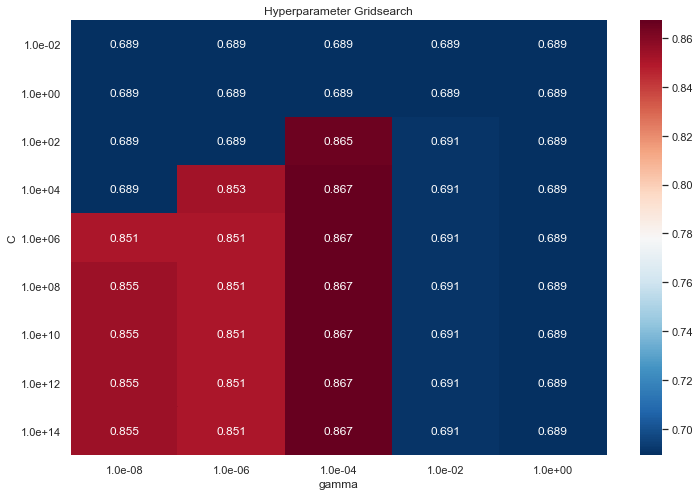

In [15]:
# scientific notation for the labels
xlabels = ['{:.1e}'.format(x) for x in gamma_candidates]
ylabels = ['{:.1e}'.format(x) for x in C_candidates]
# draw heatmap with the pivot table
print('Red for higher acc, Blue for lower acc')
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.heatmap(
    data=heatmap_data.pivot(index='C', columns='gamma', values='acc'),
    xticklabels=xlabels, yticklabels=ylabels,
    annot=True, fmt='.3f', cmap='RdBu_r'
    )
ax.set_title('Hyperparameter Gridsearch')
ax.tick_params(labelrotation=0)

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [16]:
best_model = SVC(**best_params)
best_model = best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.90625
